# Quantum Fourier Transform

In this tutorial, we introduce the quantum fourier transform (QFT), derive the circuit, and implement it using Qiskit. We show how to run QFT on a simulator and a five qubit device.

## Contents
1. [Introduction](#introduction)
2. [Example 1: 1-qubit QFT](#example1)
3. [The Quantum Fourier transform](#qfteqn)
4. [The circuit that implements QFT](#circuit)
5. [Example 2: 3-qubit QFT](#example1)
6. [A note about the form of the QFT circuit](#formnote)
7. [Qiskit Implementation](#implementation)
    - [Running QFT on a simulator](#implementationsim)
    - [Running QFT on a real quantum device](#implementationdev)
8. [Problems](#problems)
9. [References](#references)

## 1. Introduction <a id='introduction'></a>

The Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT) is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. It is part of many quantum algorithms, most notably Shor's factoring algorithm and quantum phase estimation. 

The discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

Similarly, the quantum Fourier transform acts on a quantum state $\sum_{i=0}^{N-1} x_i \vert i \rangle$ and maps it to the quantum state $\sum_{i=0}^{N-1} y_i \vert i \rangle$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
with $\omega_N^{jk}$ defined as above. Note that only the amplitudes of the state were affected by this transformation.

This can also be expressed as the map:
$$\vert x \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle$$

Or the unitary matrix:
$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} \omega_N^{xy} \vert y \rangle \langle x \vert$$

## 2. Example 1: 1-qubit QFT <a id='example1'></a>

Consider how the QFT operator as defined above acts on a single qubit state $\vert\psi\rangle = \alpha \vert 0 \rangle + \beta \vert 1 \rangle$. In this case, $x_0 = \alpha$, $x_1 = \beta$, and $N = 2$. Then,

$$y_0 = \frac{1}{\sqrt{2}}\left(    \alpha \exp\left(2\pi i\frac{0\times0}{2}\right) + \beta \exp\left(2\pi i\frac{1\times0}{2}\right)      \right) = \frac{1}{\sqrt{2}}\left(\alpha + \beta\right)$$

and

$$y_1 = \frac{1}{\sqrt{2}}\left(    \alpha \exp\left(2\pi i\frac{0\times1}{2}\right) + \beta \exp\left(2\pi i\frac{1\times1}{2}\right)      \right) = \frac{1}{\sqrt{2}}\left(\alpha - \beta\right)$$

such that the final result is the state 

$$U_{QFT}\vert\psi\rangle = \frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle$$

This operation is exactly the result of applying the Hadamard operator ($H$) on the qubit:

$$H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$

If we apply the $H$ operator to the state $\vert\psi\rangle = \alpha \vert 0 \rangle + \beta \vert 1 \rangle$, we obtain the new state:

$$\frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle 
\equiv \tilde{\alpha}\vert 0 \rangle + \tilde{\beta}\vert 1 \rangle$$

Notice how the Hadamard gate performs the discrete Fourier transform for $N = 2$ on the amplitudes of the state. 

## 3. The Quantum Fourier transform<a id="qfteqn"></a>

So what does the quantum Fourier transform look like for larger $N$? Let's derive a circuit for $N=2^n$, $QFT_N$ acting on the state $\vert x \rangle = \vert x_1\ldots x_n \rangle$ where $x_1$ is the most significant bit.

\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle ~\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 \ldots y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } \vert y_1 \ldots y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials} 
\\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding} 
\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1} 
\\
& = \frac{1}{\sqrt{N}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right) 
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right) 
\end{aligned}

## 4. The circuit that implements QFT <a name="circuit"></a>

The circuit that implements QFT makes use of two gates. The first one is a single-qubit Hadamard gate, $H$, that you already know. From the discussion in [Example 1](#example1) above, you have already seen that the action of $H$ on the single-qubit state $\vert x_k\rangle$ is

$$H\vert x_k \rangle = \vert0\rangle + \exp\left(\frac{2\pi i}{2}x_k\right)\vert1\rangle$$

The second is a two-qubit controlled rotation $CROT_k$ given in block-diagonal form as 

$$CROT_k = \left[\begin{matrix}
I&0\\
0&UROT_k\\
\end{matrix}\right]$$
where 
$$UROT_k = \left[\begin{matrix}
1&0\\
0&\exp\left(\frac{2\pi i}{2^k}\right)\\
\end{matrix}\right]$$

The action of $CROT_k$ on the two-qubit state $\vert x_jx_k\rangle$ where the first qubit is the control and the second is the target is given by

$$CROT_k\vert x_j0\rangle = \vert x_j0\rangle$$
and
$$CROT_k\vert x_j1\rangle = \exp\left( \frac{2\pi i}{2^k}x_j \right)\vert x_j1\rangle$$

Given these two gates, a circuit that implements [an n-qubit QFT](#qfteqn) is shown below.

<img src="images/qft.png">

The circuit operates as follows. We start with an n-qubit input state $\vert x_1x_2\ldots x_n\rangle$.

<ol>
<li> After the first Hadamard gate on qubit 1, the state is transformed from the input state to 

$$
H_1\vert x_1x_2\ldots x_n\rangle = 
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

<li> After the $CROT_2$ gate on qubit 1 controlled by qubit 2, the state is transformed to

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

<li> After the application of the last $CROT_n$ gate on qubit 1 controlled by qubit $n$, the state becomes

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x_n + 
\frac{2\pi i}{2^{n-1}}x_{n-1} + 
\ldots + 
\frac{2\pi i}{2^2}x_2 + 
\frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

Noting that 

$$
x = 2^{n-1}x_1 + 2^{n-2}x_2 + \ldots + 2^1x_{n-1} + 2^0x_n
$$

we can write the above state as 

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x 
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

<li> After the application of a similar sequence of gates for qubits $2\ldots n$, we find the final state to be

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x 
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^{n-1}}x 
\right)
\vert1\rangle\right]
\otimes
\ldots
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^{2}}x 
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^{1}}x 
\right)
\vert1\rangle\right]
$$
which is exactly the QFT of the input state as derived <a href="#qfteqn">above</a> with the caveat that the order of the qubits is reversed in the output state.
</ol>

## 5. Example 2: 3-qubit QFT <a id='example2'></a>

The steps to creating the circuit for $\vert y_1y_2y_3\rangle = QFT_8\vert x_1x_2x_3\rangle$ would be:

<ol>
<li> Apply a Hadamard gate to $\vert x_3 \rangle$

$$
\psi_1 = 
\vert x_1\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(\frac{2\pi i}{2}x_3\right) 
\vert1\rangle\right]
$$

<li> Apply a $CROT_2$ gate to $\vert x_3\rangle$ depending on $\vert x_2\rangle$

$$
\psi_2 = 
\vert x_1\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_3
\right) 
\vert1\rangle\right]
$$

<li> Apply a $CROT_3$ gate to $\vert x_3\rangle$ depending on $\vert x_1\rangle$

$$
\psi_3 = 
\vert x_1\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_1 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_3
\right) 
\vert1\rangle\right]
$$

<li> Apply a Hadamard gate to $\vert x_2 \rangle$

$$
\psi_4 = 
\vert x_1\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_1 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_3
\right) 
\vert1\rangle\right]
$$

<li> Apply a $CROT_2$ gate to $\vert x_2\rangle$ depending on $\vert x_1\rangle$

$$
\psi_5 = 
\vert x_1\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_1 + \frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_1 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_3
\right) 
\vert1\rangle\right]
$$

<li> Apply a Hadamard gate to $\vert x_1\rangle$

$$
\psi_6 = 
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_1 + \frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_1 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_3
\right) 
\vert1\rangle\right]
$$

<li> Keep in mind the reverse order of the output state relative to the desired QFT. Therefore, measure the bits in reverse order, that is $y_3 = x_1, y_2 = x_2, y_1 = x_3$.

## 6. A note about the form of the QFT circuit <a id="formnote"></a>

The example above demonstrates a very useful form of the QFT for $N=2^n$. Note that only the last qubit depends on the values of all the other input qubits and each further bit depends less and less on the input qubits. This becomes important in physical implementations of the QFT, where nearest-neighbor couplings are easier to achieve than distant couplings between qubits.

## 7. Qiskit Implementation<a id='implementation'></a>

In Qiskit, the implementation of the $CROT$ gate used in the discussion above is a controlled phase rotation gate. This gate is defined in [OpenQASM](https://github.com/QISKit/openqasm) as

$$
CU_1(\theta) =
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\theta}\end{bmatrix}
$$

Hence, the mapping from the $CROT_k$ gate in the discussion above into the $CU_1$ gate is found from the equation

$$
\theta = 2\pi/2^k = \pi/2^{k-1}
$$

It is instructive to write out the relevant code for the 3-qubit case before generalizing to the $n$-qubit case. In Qiskit, it is:
```
q = QuantumRegister(3)
c = ClassicalRegister(3)

qft3 = QuantumCircuit(q, c)
qft3.h(q[0])
qft3.cu1(math.pi/2.0, q[1], q[0]) # CROT_2 from q[1] to q[0]
qft3.cu1(math.pi/4.0, q[2], q[0]) # CROT_3 from q[2] to q[0]
qft3.h(q[1])
qft3.cu1(math.pi/2.0, q[2], q[1]) # CROT_2 from q[2] to q[1]
qft3.h(q[2])
```

Following the above example, the case for $n$ qubits can be generalized as:
```
def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        circ.h(q[j])
        for k in range(j+1,n):
            circ.cu1(math.pi/float(2**(k-j)), q[k], q[j])
```

We will now implement the three-qubit QFT as discussed above. We first create a state whose QFT is known. The output after a QFT is applied to this special state is $\vert001\rangle$.

In [1]:
import math

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

In [2]:
IBMQ.load_account()

First let's define the QFT function, as well as a function that creates a state from which a QFT will return 001:

In [3]:
def input_state(circ, q, n):
    """n-qubit input state for QFT that produces output 1."""
    for j in range(n):
        circ.h(q[j])
        circ.u1(-math.pi/float(2**(j)), q[j])
        
def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        circ.h(q[j])
        for k in range(j+1,n):
            circ.cu1(math.pi/float(2**(k-j)), q[k], q[j])
        circ.barrier()
    swap_registers(circ, q, n)
    
def swap_registers(circ, q, n):
    for j in range(math.floor(n/2)):
        circ.swap(q[j], q[n-j-1])
return circ

Let's now implement a QFT on a prepared three qubit input state that should return $001$:

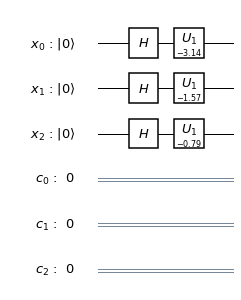

In [4]:
q = QuantumRegister(3, 'x')
c = ClassicalRegister(3, 'c')
qft3 = QuantumCircuit(q, c)

# first, prepare the state that should return 001 and draw that circuit
input_state(qft3, q, 3)

qft3.draw(output='mpl')

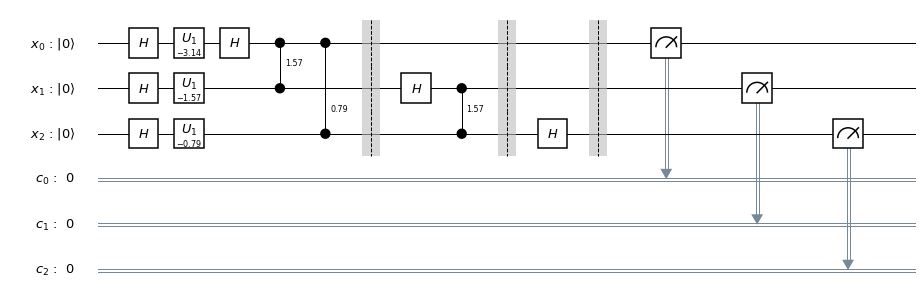

In [5]:
# next, do a qft on the prepared state and draw the entire circuit
qft(qft3, q, 3)
for i in range(3):
    qft3.measure(q[i], c[i])
    
qft3.draw(output='mpl')

## 7a. Running QFT on a simulator<a id="implementationsim"></a>

In [6]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")

simulate = execute(qft3, backend=backend, shots=1024).result()
simulate.get_counts()

{'001': 1024}

We indeed see that the outcome is always $001$ when we execute the code on the simulator.

## 7b. Running QFT on a real quantum device<a id="implementationdev"></a>

We then see how the same circuit can be executed on real-device backends.

In [7]:
# Use the IBMQ Vigo device with 5 qubits
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_vigo')
shots = 2048
job_exp = execute(qft3, backend=backend, shots=shots)
job_monitor(job_exp)

Job Status: job has successfully run


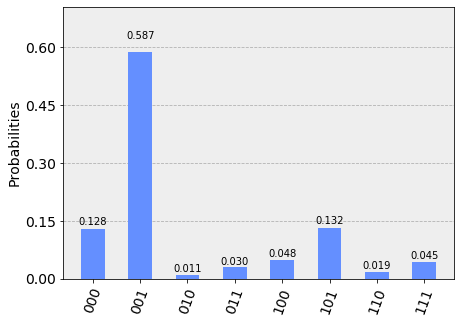

In [8]:
results = job_exp.result()
plot_histogram(results.get_counts())

We see that the highest probability outcome is still $001$ when we execute the code on a real device.

## 8. Problems

1. The [above implementation](#implementation) of QFT was tested by using a special input state for which QFT(input state) = 001. Implement an input state for which QFT(input state) = 100.
2. The [above implementation](#implementation) of QFT was tested by using a special input state for which QFT(input state) = 001. Implement an input state for which QFT(input state) = 101.

## 9. References

1. M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

In [9]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.10.3',
 'qiskit-terra': '0.8.1',
 'qiskit-ignis': '0.1.1',
 'qiskit-aer': '0.2.1',
 'qiskit-ibmq-provider': '0.2.2',
 'qiskit-aqua': '0.5.1'}